# 训练人工神经网络

近年来，人工神经网络蓬勃发展，在神经科学研究中也扮演重要角色。brainstate作为面向脑动力学建模的高性能计算框架，也支持人工神经网络训练，便于神经动力学模型和人工神经网络的对接。

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import optax

import brainstate as bst

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
/home/lyumuyang/miniconda3/envs/py311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
bst.__version__

'0.1.0'

## 准备数据集

In [3]:
X = np.linspace(0, 1, 100)[:, None]
Y = 0.8 * X ** 2 + 0.1 + np.random.normal(0, 0.1, size=X.shape)

In [4]:
def dataset(batch_size):
  while True:
    idx = np.random.choice(len(X), size=batch_size)
    yield X[idx], Y[idx]

## 人工神经网络模块类的定义
在定义人工神经网络模块时，模块需要继承基类 ``brainstate.nn.Module``。

模型中所有需要改变的量都需封装在 ``State`` 对象中。其中，需要在训练中更新的模型参数需封装在``ParamState``（是``State`` 的子类）对象中。

定义人工神经网络类，需要在类方法``__init__()``中定义网络中的层（注意要首先初始化基类``super().__init__()``）；需要在类方法``__call__()``中定义网络前向传播的方法。

In [5]:
class Linear(bst.nn.Module):
  def __init__(self, din: int, dout: int):
    super().__init__()
    self.w = bst.ParamState(bst.random.rand(din, dout))
    self.b = bst.ParamState(jnp.zeros((dout,)))

  def __call__(self, x):
    return x @ self.w.value + self.b.value

In [6]:
class Count(bst.State):
  pass

In [7]:
class MLP(bst.nn.Module):
  def __init__(self, din, dhidden, dout):
    super().__init__()
    self.count = Count(jnp.array(0))
    self.linear1 = Linear(din, dhidden)
    self.linear2 = Linear(dhidden, dout)

  def __call__(self, x):
    self.count.value += 1
    x = self.linear1(x)
    x = jax.nn.relu(x)
    x = self.linear2(x)
    return x

In [8]:
model = MLP(din=1, dhidden=32, dout=1)

## 优化器设置
``brainstate.optim``提供了各种各样的优化器可供选择。

优化器实例化时，需要传入模型中计划使用此优化器更新的``State``实例。

此处用``brainstate.nn.Module.states()``收集了该模型中所有网络节点和子节点的``State``，并且限制了所收集``State``的类型为``brainstate.ParamState``（在此例的模型中，``State``实例还有``Count``类，而这并非是需要此优化器更新的，因此需要加以类型限制）。

In [9]:
optimizer = bst.optim.OptaxOptimizer(model.states(bst.ParamState), optax.sgd(1e-3))

## 模型训练
模型训练时，使用``brainstate.augment.grad``函数来计算梯度，需要传入损失函数和需计算梯度的参数``State``。

然后将梯度通过``update()``传给先前定义好的优化器，进行更新。

使用``brainstate.compile.jit``函数装饰单步训练函数，使之可以即时编译，提高计算效率和性能。

In [10]:
@bst.compile.jit
def train_step(batch):
  x, y = batch

  def loss_fn():
    return jnp.mean((y - model(x)) ** 2)

  grads = bst.augment.grad(loss_fn, model.states(bst.ParamState))()
  optimizer.update(grads)

## 模型测试
使用``brainstate.compile.jit``函数装饰单步测试函数，使之可以即时编译，提高计算效率和性能。

In [11]:
@bst.compile.jit
def test_step(batch):
  x, y = batch
  y_pred = model(x)
  loss = jnp.mean((y - y_pred) ** 2)
  return {'loss': loss}

## 训练进行

In [12]:
total_steps = 10_000
for step, batch in enumerate(dataset(32)):
  train_step(batch)

  if step % 1000 == 0:
    logs = test_step((X, Y))
    print(f"step: {step}, loss: {logs['loss']}")

  if step >= total_steps - 1:
    break

print('times called:', model.count.value)

y_pred = model(X)

step: 0, loss: 29.513227462768555
step: 1000, loss: 0.08835460245609283
step: 2000, loss: 0.027202898636460304
step: 3000, loss: 0.015465355478227139
step: 4000, loss: 0.012763087637722492
step: 5000, loss: 0.01192516554147005
step: 6000, loss: 0.011579394340515137
step: 7000, loss: 0.011381025426089764
step: 8000, loss: 0.01126654352992773
step: 9000, loss: 0.011209072545170784
times called: 10010


## 可视化

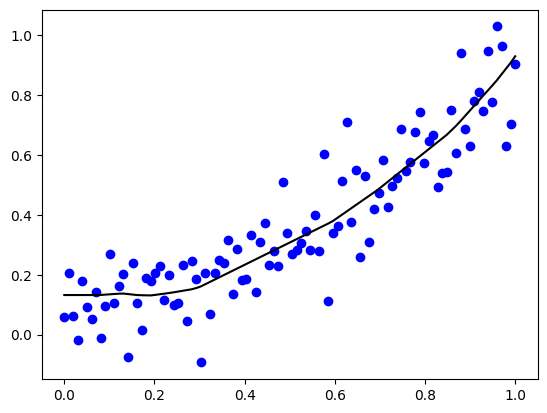

In [13]:
plt.scatter(X, Y, color='blue')
plt.plot(X, y_pred, color='black')
plt.show()